In [399]:
from pathlib import Path

import pandas as pd
import numpy as np
import datetime as dt

import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns

from ray import tune
from ray.air import session
from ray.train import Checkpoint

from recsys24_daos.utils.notebooks import download_plotly, download_matplotlib

pio.templates.default = 'seaborn'
sns.set_theme()

In [400]:
SPLITS_FREQ = 'W-THU'
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
CUTOFF_DATE = dt.datetime.fromisoformat("2023-07-29")
RAY_RESULTS_PATH = '~/ray_results'
ORG_NAME = 'Decentraland'
LAST_SPLITS = 10 # Used for asserts

OPTIM_METRIC = 'map@10'
OPTIM_MODE = 'max'

SAMPLES_PER_SPLIT: int = 100 # See 07_microsoft_tuning.ipynb

In [401]:
RAY_RESULTS_PATH = Path(RAY_RESULTS_PATH).expanduser()
assert RAY_RESULTS_PATH.is_dir()

## Get ray results

In [402]:
last_experiments = sorted(RAY_RESULTS_PATH.glob(f'LightGCN_optim={OPTIM_METRIC},dao={ORG_NAME},freq={SPLITS_FREQ},normalize={SPLITS_NORMALIZE},cutoff_date={CUTOFF_DATE.isoformat()},fold=*[0-9]_*'))
print(f"Found {len(last_experiments)} experiments")

class TrainLightGCN:
    def __init__(self):
        raise NotImplementedError

tuners = [ tune.Tuner.restore(str(l), TrainLightGCN) for l in last_experiments ]
result_grids = [ tuner.get_results() for tuner in tuners ]
assert len(result_grids) == LAST_SPLITS

for i, rg in enumerate(result_grids):
    print(f"Fold: {i}, {rg.num_terminated} finished, {rg.num_errors} errors")
    assert rg.num_terminated == SAMPLES_PER_SPLIT
    assert rg.num_errors == 0, "There should be no errors"

Found 10 experiments
Fold: 0, 100 finished, 0 errors
Fold: 1, 100 finished, 0 errors
Fold: 2, 100 finished, 0 errors
Fold: 3, 100 finished, 0 errors
Fold: 4, 100 finished, 0 errors
Fold: 5, 100 finished, 0 errors
Fold: 6, 100 finished, 0 errors
Fold: 7, 100 finished, 0 errors
Fold: 8, 100 finished, 0 errors
Fold: 9, 100 finished, 0 errors


In [403]:
# Checking data from just one experiment
pd.concat(result_grids[0]._experiment_analysis.trial_dataframes.values())

iteration      loss   mf_loss  emb_loss  model_recall  model_ndcg  \
0           5  0.082062  0.079736  0.002326      0.003058    0.006081   
1          10  0.113612  0.109127  0.004485      0.018885    0.020960   
2          15  0.122054  0.115901  0.006153      0.020803    0.014957   
3          20  0.132649  0.125211  0.007438      0.016307    0.012001   
4          25  0.146193  0.137539  0.008654      0.006355    0.007280   
..        ...       ...       ...       ...           ...         ...   
0           5  0.113494  0.113015  0.000479      0.003597    0.001900   
1          10  0.064540  0.063850  0.000690      0.000000    0.000000   
2          15  0.047351  0.046514  0.000837      0.006715    0.005127   
3          20  0.038447  0.037492  0.000954      0.014029    0.013740   
4          25  0.030616  0.029562  0.001055      0.014029    0.014979   

    model_precision  model_map  precision@5    ndcg@5  ...  hostname  \
0          0.005755   0.002203     0.253237  0.437817  ...   lamarck   
1          0.020144   0.009064     0.233094  0.391968  ...   lamarck   
2          0.015827   0.005971     0.251799  0.445208  ...   lamarck   
3          0.012950   0.006139     0.269065  0.467835  ...   lamarck   
4          0.007194   0.002368     0.244604  0.424119  ...   lamarck   
..              ...        ...          ...       ...  ...       ...   
0          0.001439   0.000899     0.217266  0.402380  ...   lamarck   
1          0.000000   0.000000     0.225899  0.405237  ...   lamarck   
2          0.004317   0.002058     0.224460  0.402302  ...   lamarck   
3          0.012950   0.005941     0.230216  0.403320  ...   lamarck   
4          0.012950   0.007362     0.235971  0.412731  ...   lamarck   

          node_ip  time_since_restore  iterations_since_restore  config/fold  \
0   147.96.81.131           17.080780                         1            0   
1   147.96.81.131           36.636501                         2            0   
2   147.96.81.131           56.247183                         3            0   
3   147.96.81.131           77.384388                         4            0   
4   147.96.81.131           97.299589                         5            0   
..            ...                 ...                       ...          ...   
0   147.96.81.131           41.923079                         1            0   
1   147.96.81.131          116.989168                         2            0   
2   147.96.81.131          195.951722                         3            0   
3   147.96.81.131          275.060860                         4            0   
4   147.96.81.131          345.514864                         5            0   

    config/batch_size  config/embedding_dim  config/conv_layers  \
0                   9                    38                   4   
1                   9                    38                   4   
2                   9                    38                   4   
3                   9                    38                   4   
4                   9                    38                   4   
..                ...                   ...                 ...   
0                   7                   217                   3   
1                   7                   217                   3   
2                   7                   217                   3   
3                   7                   217                   3   
4                   7                   217                   3   

    config/learning_rate  config/l2  
0                 0.1240   0.000004  
1                 0.1240   0.000004  
2                 0.1240   0.000004  
3                 0.1240   0.000004  
4                 0.1240   0.000004  
..                   ...        ...  
0                 0.0005   0.000028  
1                 0.0005   0.000028  
2                 0.0005   0.000028  
3                 0.0005   0.000028  
4                 0.0005   0.000028  

[1275 rows x 38 columns]

## Create dataframe with all results

In [404]:
# Read dataframe and drop some unneeded columns
# rdf = pd.concat([rg.get_dataframe(TARGET, 'max') for rg in result_grids ])
rdf = pd.concat([ pd.concat(rg._experiment_analysis.trial_dataframes.values()) for rg in result_grids ])

drop_cols = [
    'timestamp', 'node_ip', 'pid', 'hostname', 'time_since_restore', # 'checkpoint_dir_name', 'trial_id', # 'logdir'
    'model_recall', 'model_ndcg', 'model_precision', 'model_map', 
    'time_train', 'time_test', 'time_total_s', 'time_this_iter_s',
    'training_iteration', 'iterations_since_restore',
    # 'recall@5', 'map@5', 'recall@10', 'map@10',
]
rdf = rdf.drop(columns=drop_cols)
rdf = rdf.drop(columns=['date']).rename(columns={'config/__trial_index__': 'config/fold', 'iteration':'config/iteration'})
# rdf = rdf[rdf['done']]
print(rdf.columns)

for c in ['config/batch_size']: #, 'config/embedding_dim']:
    rdf[c] = 2**rdf[c]

# rdf[(rdf['config/fold'] >= 1) & (rdf['iteration'] > 10)].sort_values('precision@5').tail()
# Display some results
rdf.sort_values(OPTIM_METRIC).tail()

Index(['config/iteration', 'loss', 'mf_loss', 'emb_loss', 'precision@5',
       'ndcg@5', 'recall@5', 'map@5', 'precision@10', 'ndcg@10', 'recall@10',
       'map@10', 'time_total_train', 'time_total_test', 'done', 'trial_id',
       'config/fold', 'config/batch_size', 'config/embedding_dim',
       'config/conv_layers', 'config/learning_rate', 'config/l2'],
      dtype='object')


config/iteration      loss   mf_loss  emb_loss  precision@5    ndcg@5  \
4                25  0.043679  0.043398  0.000281     0.306542  0.567555   
3                20  0.014810  0.013543  0.001267     0.321495  0.586879   
5                30  0.918408  0.915768  0.002639     0.287850  0.567120   
4                25  0.053500  0.048636  0.004864     0.340187  0.611965   
2                15  0.903263  0.901345  0.001918     0.310280  0.618238   

   recall@5     map@5  precision@10   ndcg@10  ...  time_total_train  \
4  0.671851  0.488954      0.223364  0.691881  ...        180.624061   
3  0.721006  0.500697      0.223364  0.695770  ...        216.724267   
5  0.610303  0.491400      0.223364  0.714104  ...         78.443872   
4  0.742256  0.530336      0.223364  0.709683  ...        118.355091   
2  0.698020  0.553059      0.223364  0.731740  ...         11.736402   

   time_total_test   done  trial_id  config/fold config/batch_size  \
4         4.944447  False  56af58e9            7               512   
3         4.621286  False  c2d30563            7               256   
5         1.016398  False  dfb5440d            7               256   
4         3.651055  False  0e84f93a            7               512   
2         0.765456  False  dfb5440d            7               256   

   config/embedding_dim  config/conv_layers  config/learning_rate  \
4                   290                   4                0.0433   
3                   175                   2                0.0017   
5                     1                   1                0.5557   
4                    47                   4                0.0763   
2                     1                   1                0.5557   

      config/l2  
4  1.014523e-07  
3  3.043272e-05  
5  3.352188e-05  
4  4.372358e-06  
2  3.352188e-05  

[5 rows x 22 columns]

## Assert that every experiment was completed

In [405]:
_config_cols = [ c for c in rdf.columns if c.startswith('config/') and c != 'config/iteration' ]

# _s = rdf.groupby(_config_cols).size().groupby('config/fold').size()
# print(_s)

# Cuidado, no es aleatorio sin reemplazamiento, por lo que
# alguna config, por casualidad, puede estar repetida y es necesario
# usar trial_id
_config_cols.append('trial_id')

_s = rdf.groupby(_config_cols).size().groupby('config/fold').size()
print(_s)
assert all(_s == SAMPLES_PER_SPLIT), "Insufficient number of samples" 

config/fold
0    100
1    100
2    100
3    100
4    100
5    100
6    100
7    100
8    100
9    100
dtype: int64


## Get total execution time

In [406]:
_config_cols = ['trial_id'] + [ c for c in rdf.columns if c.startswith('config/') and c != 'config/iteration' ]

last_iteration_time = rdf.groupby(_config_cols)['time_total_train'].max()
print(last_iteration_time)
print("Mean exec time: ", dt.timedelta(seconds=last_iteration_time.mean()))
print("Total exec time:", dt.timedelta(seconds=last_iteration_time.sum()))

trial_id  config/fold  config/batch_size  config/embedding_dim  config/conv_layers  config/learning_rate  config/l2   
009e8dde  7            256                817                   3                   0.0002                1.797410e-07    318.930889
00af43fc  0            256                1                     2                   0.5652                1.440015e-05    302.846785
00ba874a  6            128                306                   4                   0.0065                8.923120e-07    380.318138
00cfaf10  8            256                75                    5                   0.0003                1.397536e-06    315.596252
00df7866  0            512                2                     3                   0.0564                3.646905e-07    303.956969
                                                                                                                             ...    
fe889043  4            64                 24                    4                  

In [407]:
# Number of iterations
rdf.groupby('trial_id')['config/iteration'].max().describe()

count    1000.000000
mean       46.795000
std        39.852116
min         5.000000
25%        20.000000
50%        35.000000
75%        65.000000
max       200.000000
Name: config/iteration, dtype: float64

## Get baseline data

In [408]:
bdf = pd.read_csv("../data/cache/baseline.csv", parse_dates=['t'], index_col='t')
bdf = bdf[bdf.index <= CUTOFF_DATE][-LAST_SPLITS:]
bdf.mean()

precision@5     0.221133
ndcg@5          0.317652
map@5           0.236604
recall@5        0.352186
precision@10    0.195841
ndcg@10         0.415757
map@10          0.310075
recall@10       0.625331
precision@15    0.168421
ndcg@15         0.477980
map@15          0.344976
recall@15       0.820536
dtype: float64

In [409]:
bdf

precision@5    ndcg@5     map@5  recall@5  precision@10   ndcg@10  \
t                                                                               
2023-05-11     0.208633  0.385956  0.329278  0.428333      0.164029  0.446069   
2023-05-18     0.257988  0.279337  0.169492  0.208697      0.228994  0.317482   
2023-05-25     0.224590  0.363931  0.271213  0.444346      0.178689  0.432331   
2023-06-01     0.287129  0.367923  0.297377  0.420402      0.240594  0.497208   
2023-06-08     0.242735  0.314490  0.206947  0.375753      0.216239  0.435318   
2023-06-15     0.227273  0.307695  0.241792  0.338186      0.201515  0.406611   
2023-06-22     0.183784  0.300084  0.240828  0.327366      0.143919  0.356396   
2023-06-29     0.228037  0.368931  0.301905  0.454473      0.223364  0.569957   
2023-07-06     0.175100  0.217796  0.126806  0.202459      0.201205  0.338701   
2023-07-13     0.176056  0.270382  0.180403  0.321848      0.159859  0.357493   

              map@10  recall@10  precision@15   ndcg@15    map@15  recall@15  
t                                                                             
2023-05-11  0.378961   0.583253      0.152998  0.539091  0.419648   0.881293  
2023-05-18  0.236634   0.343019      0.220907  0.375532  0.287473   0.508050  
2023-05-25  0.328419   0.649313      0.152459  0.475776  0.358614   0.777379  
2023-06-01  0.394871   0.753990      0.190759  0.573062  0.429046   1.000000  
2023-06-08  0.293672   0.723698      0.158405  0.461744  0.309795   0.804894  
2023-06-15  0.314845   0.602116      0.191919  0.519772  0.371795   0.951136  
2023-06-22  0.286072   0.488397      0.136036  0.438287  0.321817   0.755448  
2023-06-29  0.417010   1.000000      0.148910  0.569957  0.417010   1.000000  
2023-07-06  0.212009   0.546963      0.185810  0.399761  0.256185   0.737231  
2023-07-13  0.238254   0.562567      0.146009  0.426820  0.278381   0.789927

(0.0, 1.0)

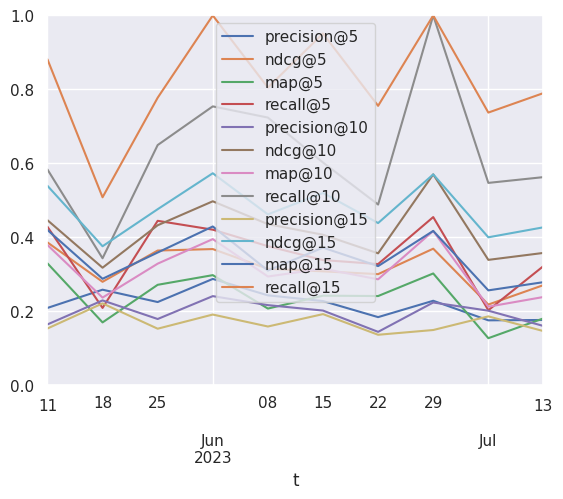

In [410]:
ax = bdf.plot()
ax.set_ylim(0, 1)

### Get perfect data

In [411]:
pdf = pd.read_csv("../data/cache/perfect.csv", parse_dates=['t'], index_col='t')
pdf = pdf[pdf.index <= CUTOFF_DATE][-LAST_SPLITS:]
pdf.mean()

precision@5     0.478408
ndcg@5          1.000000
map@5           0.947672
recall@5        0.947672
precision@10    0.281155
ndcg@10         1.000000
map@10          0.989542
recall@10       0.989542
precision@15    0.196069
ndcg@15         1.000000
map@15          0.998317
recall@15       0.998317
dtype: float64

In [412]:
pdf

precision@5  ndcg@5     map@5  recall@5  precision@10  ndcg@10  \
t                                                                            
2023-05-11     0.443165     1.0  0.963084  0.963084      0.252518      1.0   
2023-05-18     0.595266     1.0  0.856496  0.856496      0.411834      1.0   
2023-05-25     0.431148     1.0  0.947488  0.947488      0.258197      1.0   
2023-06-01     0.522772     1.0  0.974347  0.974347      0.284158      1.0   
2023-06-08     0.496610     1.0  0.953844  0.953844      0.285593      1.0   
2023-06-15     0.506061     1.0  0.950594  0.950594      0.292424      1.0   
2023-06-22     0.421622     1.0  0.967603  0.967603      0.236486      1.0   
2023-06-29     0.439252     1.0  0.994215  0.994215      0.223364      1.0   
2023-07-06     0.491566     1.0  0.911162  0.911162      0.314859      1.0   
2023-07-13     0.436620     1.0  0.957890  0.957890      0.252113      1.0   

              map@10  recall@10  precision@15  ndcg@15    map@15  recall@15  
t                                                                            
2023-05-11  0.998340   0.998340      0.169784      1.0  1.000000   1.000000  
2023-05-18  0.957778   0.957778      0.309270      1.0  0.991590   0.991590  
2023-05-25  0.990280   0.990280      0.180328      1.0  0.999036   0.999036  
2023-06-01  0.998200   0.998200      0.190759      1.0  1.000000   1.000000  
2023-06-08  0.997175   0.997175      0.192655      1.0  1.000000   1.000000  
2023-06-15  0.996786   0.996786      0.197475      1.0  1.000000   1.000000  
2023-06-22  0.995293   0.995293      0.161712      1.0  0.999578   0.999578  
2023-06-29  1.000000   1.000000      0.148910      1.0  1.000000   1.000000  
2023-07-06  0.974473   0.974473      0.229987      1.0  0.993410   0.993410  
2023-07-13  0.987097   0.987097      0.179812      1.0  0.999560   0.999560

(0.0, 1.0)

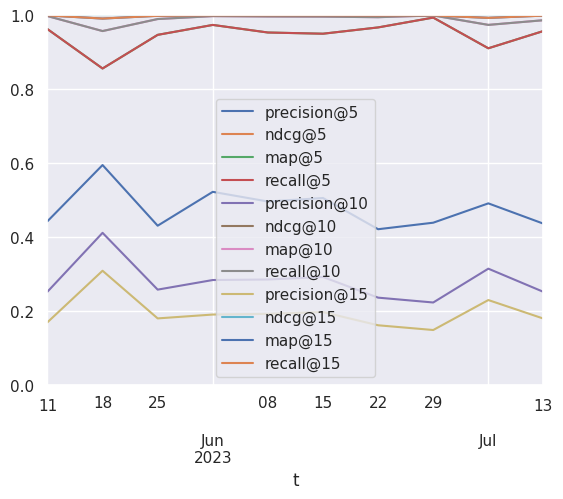

In [413]:
ax = pdf.plot()
ax.set_ylim(0, 1)

## Explore hparams

In [414]:
# Primero, obtenemos la mejor iteración, como si hubiesemos hecho early stopping
hdf = pd.concat(rg.get_dataframe(OPTIM_METRIC, OPTIM_MODE) for rg in result_grids)
hdf

iteration       loss   mf_loss  emb_loss  model_recall  model_ndcg  \
0          60   0.168809  0.153714  0.015095      0.030755    0.028565   
1          25   0.049176  0.012859  0.036317      0.047962    0.038274   
2          70   0.041233  0.019448  0.021785      0.019604    0.020920   
3          30  10.793518  2.405839  8.387679      0.000899    0.000944   
4          10   0.095893  0.086937  0.008956      0.003597    0.002206   
..        ...        ...       ...       ...           ...         ...   
95          5   0.165999  0.061425  0.104574      0.031221    0.025300   
96          5   0.041006  0.038425  0.002581      0.044944    0.042082   
97         10   0.064978  0.064271  0.000707      0.051182    0.040561   
98          5   0.079672  0.046628  0.033044      0.059379    0.051303   
99          5   0.153857  0.115970  0.037887      0.050372    0.043059   

    model_precision  model_map  precision@5    ndcg@5  ...        node_ip  \
0          0.021583   0.014111     0.261871  0.482229  ...  147.96.81.131   
1          0.024460   0.022838     0.277698  0.501743  ...  147.96.81.131   
2          0.018705   0.010122     0.269065  0.468755  ...  147.96.81.131   
3          0.001439   0.000180     0.251799  0.449034  ...  147.96.81.131   
4          0.001439   0.001199     0.221583  0.405007  ...  147.96.81.131   
..              ...        ...          ...       ...  ...            ...   
95         0.018310   0.018991     0.169014  0.273144  ...  147.96.81.131   
96         0.026761   0.024530     0.198592  0.348659  ...  147.96.81.131   
97         0.033803   0.022187     0.226761  0.385422  ...  147.96.81.131   
98         0.033803   0.032363     0.215493  0.359307  ...  147.96.81.131   
99         0.036620   0.021462     0.200000  0.340670  ...  147.96.81.131   

    time_since_restore  iterations_since_restore  config/fold  \
0           237.182472                        12            0   
1           325.767740                         5            0   
2           225.080894                        14            0   
3           335.935949                         6            0   
4           153.246691                         2            0   
..                 ...                       ...          ...   
95          499.027162                         1            9   
96          250.447917                         1            9   
97          144.779188                         2            9   
98          137.192242                         1            9   
99          376.207523                         1            9   

    config/batch_size  config/embedding_dim  config/conv_layers  \
0                   9                    38                   4   
1                   8                   648                   4   
2                   9                    30                   3   
3                   7                    24                   2   
4                   7                    42                   4   
..                ...                   ...                 ...   
95                  6                   806                   5   
96                  6                    16                   1   
97                  7                   217                   3   
98                  7                    37                   3   
99                  7                   950                   5   

    config/learning_rate  config/l2    logdir  
0                 0.1240   0.000004  1ffe5ea3  
1                 0.0176   0.000186  506e08ac  
2                 0.0484   0.000256  9ffdbd19  
3                 0.5932   0.005542  77148169  
4                 0.0012   0.000415  6124f862  
..                   ...        ...       ...  
95                0.0251   0.000106  338395b3  
96                0.0043   0.000137  b211ade6  
97                0.0005   0.000028  7b432d71  
98                0.0059   0.001852  d9a639e8  
99                0.0004   0.002358  3852f46f  

[1000 rows x 39 columns]

In [415]:
hdf['config/fold'] = hdf['config/fold'].astype(str)

fig = px.scatter(hdf, x='map@10', y='ndcg@10', color='config/fold')
fig.layout.update(showlegend=False)

download_plotly(fig, 'scatter_ndcg_map.pdf')
fig

In [416]:
fig = px.scatter(hdf, x=OPTIM_METRIC, y='precision@10', color='config/fold')
fig.layout.update(showlegend=False)

download_plotly(fig, 'scatter_map_precision.pdf')
fig

In [417]:
def plotly_scatter_config(config, log=True):
    config_cols = [c for c in hdf.columns if c.startswith('config/') ]
    return px.scatter(hdf, x=config, y=OPTIM_METRIC, color='config/fold', marginal_x='rug', marginal_y='rug', log_x=log, hover_data=config_cols)

plotly_scatter_config('config/embedding_dim')

In [418]:
plotly_scatter_config('config/learning_rate')

In [419]:
plotly_scatter_config('config/l2')

In [420]:
plotly_scatter_config('config/batch_size', log=False)

## Choosing best hparams

### Per fold

In [421]:
# We fix the total time in less than 250 so it has time to do the same number of iterations with the next fold
# best = rdf[rdf['time_total_train'] + rdf['time_total_test'] < 250].sort_values(OPTIM_METRIC).drop_duplicates('config/fold', keep='last').set_index('config/fold').sort_index()
best = rdf.sort_values(OPTIM_METRIC).drop_duplicates('config/fold', keep='last').set_index('config/fold').sort_index()
best

config/iteration      loss   mf_loss  emb_loss  precision@5  \
config/fold                                                                
0                          20  2.629414  1.533245  1.096168     0.274820   
1                          30  0.431897  0.409332  0.022565     0.324260   
2                          45  0.181792  0.172447  0.009346     0.280328   
3                           5  0.255664  0.254833  0.000831     0.394059   
4                          75  0.313558  0.310867  0.002691     0.350847   
5                          85  0.184556  0.174617  0.009939     0.289394   
6                         125  0.846347  0.841061  0.005286     0.287838   
7                          15  0.903263  0.901345  0.001918     0.310280   
8                          35  0.010340  0.009826  0.000513     0.263454   
9                          10  0.065127  0.023561  0.041566     0.229577   

               ndcg@5  recall@5     map@5  precision@10   ndcg@10  ...  \
config/fold                                                        ...   
0            0.533089  0.588890  0.456373      0.201439  0.606282  ...   
1            0.436734  0.345719  0.291486      0.272189  0.486249  ...   
2            0.541738  0.573562  0.434213      0.199180  0.591702  ...   
3            0.567747  0.690849  0.456295      0.274257  0.663165  ...   
4            0.591459  0.647680  0.489507      0.255932  0.668391  ...   
5            0.454617  0.468068  0.359070      0.233333  0.560654  ...   
6            0.584152  0.649280  0.499543      0.204054  0.651632  ...   
7            0.618238  0.698020  0.553059      0.223364  0.731740  ...   
8            0.396441  0.431955  0.272603      0.232932  0.490734  ...   
9            0.402814  0.497570  0.298885      0.185211  0.490569  ...   

               map@10  time_total_train  time_total_test   done  trial_id  \
config/fold                                                                 
0            0.516346         85.813447         3.327729  False  636019ac   
1            0.371106         69.812954         2.478821  False  5efaadf5   
2            0.487608         46.136016         1.285662  False  0fc2919d   
3            0.545657        139.920037         4.923971  False  06a6f5ba   
4            0.569160        111.556493         2.909259  False  dbf66eea   
5            0.446157        289.214480         2.632449  False  dbbcb2e6   
6            0.558899        155.934766         3.226803  False  f46fe65f   
7            0.625411         11.736402         0.765456  False  dfb5440d   
8            0.356020        268.415208         3.434468  False  bdd7257c   
9            0.362519         87.856729         3.084392  False  569b1e88   

            config/batch_size  config/embedding_dim  config/conv_layers  \
config/fold                                                               
0                         512                   128                   4   
1                         512                     1                   4   
2                         512                     5                   3   
3                         128                   551                   2   
4                         512                     1                   2   
5                         512                     5                   3   
6                         256                     1                   1   
7                         256                     1                   1   
8                         256                   173                   2   
9                         256                    73                   5   

             config/learning_rate     config/l2  
config/fold                                      
0                          0.3644  2.332245e-05  
1                          0.8071  8.455565e-04  
2                          0.2200  5.242816e-05  
3                          0.0369  2.889943e-07  
4                          0.0610  8.521670e-05  
5                          0.2200  

precision@5     map@10
count    10.000000  10.000000
mean      0.300486   0.483888
std       0.046787   0.096052
min       0.229577   0.356020
25%       0.276197   0.389869
50%       0.288616   0.501977
75%       0.320765   0.555588
max       0.394059   0.625411

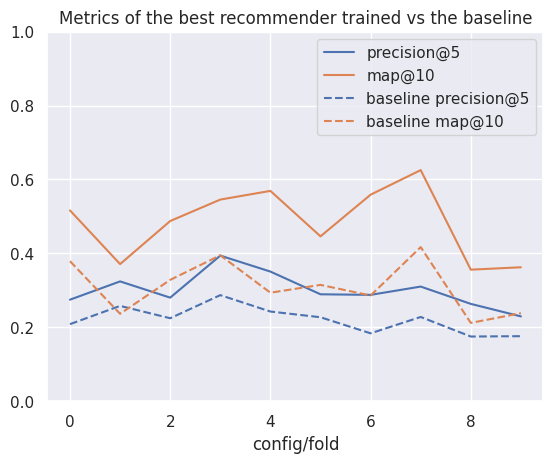

In [422]:
cols2plot = ['precision@5', 'map@10']

ax = best[cols2plot].plot()
ax.set_ylim(0, 1)

bdf[cols2plot].rename(columns='baseline {}'.format).reset_index(drop=True).plot(ax=ax, style='--', color=[l.get_color() for l in ax.lines])

plt.title("Metrics of the best recommender trained vs the baseline")
best[cols2plot].describe()

In [423]:
best[['precision@5', 'ndcg@5', 'precision@10', 'ndcg@10', 'map@5', 'map@10']].mean()

precision@5     0.300486
ndcg@5          0.512703
precision@10    0.228189
ndcg@10         0.594112
map@5           0.411103
map@10          0.483888
dtype: float64

## Realisitc model (repeating hparams)

In [424]:
config_cols = [ c for c in rdf.columns if c.startswith('config/') and c != 'config/iteration' ]
config_cols2 = config_cols + ['config/iteration']
all_configs = rdf.copy()
all_configs['config/fold'] += 1

# Leonardo Torres de Quevedo, perdoname por lo que voy a hacer
all_configs[config_cols] = all_configs[config_cols].astype(str)
all_configs = all_configs.set_index(config_cols)
all_configs_index = all_configs.index

# all_configs_index = pd.MultiIndex.from_frame(all_configs[config_cols].astype(str))[:-1]

# No podemos utilizar los indices "tal cual" pues la coma flotante
# no encaja entre un fold y otro. Así que lo convierto a string
# y luego de nuevo a coma flotante.
# La otra solución sería usar np.isclose, pero habría que programar
# varias lineas y hacer nuestra propia función de búsqueda por cada
# columna o algo así
# O también, en lugar de str, multiplicar por 10^7 (el min. es 10**-7),
# pasar a entero, y luego dividir
aux = rdf.copy()
aux[config_cols] = aux[config_cols].astype(str)
aux = aux.set_index(config_cols)
print("Index intersection:", aux.index.intersection(all_configs_index))
all_realistic = aux.loc[aux.index.intersection(all_configs_index)]
# all_realistic.index = all_realistic.index.set_levels(
#     [ pd.to_numeric(l) for l in realistic.index.levels ]
# )
all_realistic

Index intersection: MultiIndex([('1', '256',  '87', '4',                 '0.0004', ...),
            ('1', '128', '338', '2',                 '0.0005', ...),
            ('1', '128',   '4', '3',                 '0.0002', ...),
            ('1', '256', '412', '4',                 '0.0014', ...),
            ('1', '256',  '75', '5', '0.00030000000000000003', ...),
            ('1', '512',   '8', '2',                 '0.0201', ...),
            ('1', '512', '114', '4',                 '0.0001', ...),
            ('1', '512',   '5', '3',                   '0.22', ...),
            ('1', '128',  '42', '4',  '0.0012000000000000001', ...),
            ('1', '128',  '11', '4',                 '0.0011', ...),
            ...
            ('9', '128',   '7', '4',                 '0.0038', ...),
            ('9', '512',   '8', '2',                 '0.0201', ...),
            ('9', '256',  '10', '2',                 '0.0019', ...),
            ('9', '256', '412', '4',                 '0.0014', ...)

config/iteration  \
config/fold config/batch_size config/embedding_dim config/conv_layers config/learning_rate config/l2                                  
1           256               87                   4                  0.0004               2.596560689461171e-07                  5   
                                                                                           2.596560689461171e-07                 10   
                                                                                           2.596560689461171e-07                 15   
                                                                                           2.596560689461171e-07                 20   
                                                                                           2.596560689461171e-07                 25   
...                                                                                                                             ...   
9           128               338                  2                  0.0005               1.0881114993034241e-07                15   
                              217                  3                  0.0005               2.7919256933533526e-05                 5   
                                                                                           2.7919256933533526e-05                10   
                                                                                           2.7919256933533526e-05                15   
                                                                                           2.7919256933533526e-05                20   

                                                                                                                       loss  \
config/fold config/batch_size config/embedding_dim config/conv_layers config/learning_rate config/l2                          
1           256               87                   4                  0.0004               2.596560689461171e-07   0.251320   
                                                                                           2.596560689461171e-07   0.169730   
                                                                                           2.596560689461171e-07   0.131567   
                                                                                           2.596560689461171e-07   0.107076   
                                                                                           2.596560689461171e-07   0.090527   
...                                                                                                                     ...   
9           128               338                  2                  0.0005               1.0881114993034241e-07  0.025400   
                              217                  3                  0.0005               2.7919256933533526e-05  0.110300   
                                                                                           2.7919256933533526e-05  0.064978   
                                                                                           2.7919256933533526e-05  0.046559   
                                                                                           2.7919256933533526e-05  0.036895   

                                                                                                                    mf_loss  \
config/fold config/batch_size config/embedding_dim config/conv_layers config/learning_rate config/l2                          
1           256               87                   4                  0.0004               2.596560689461171e-07   0.251317   
                                                                                           2.596560689461171e-07   0.169726   
                                                                                           2.596560689461171e-07   0.131562   
                                                                        

In [425]:
def bestByFold(df):
    idx = df[OPTIM_METRIC].idxmax()
    return df.loc[idx]

best_configs = (
    all_configs.loc[all_configs.index.intersection(all_realistic.index)]
    .reset_index()
    .groupby("config/fold")
    .apply(bestByFold)
    .set_index(config_cols)
    # .rename(columns="best_{}".format)
)
best_configs

config/iteration  \
config/fold config/batch_size config/embedding_dim config/conv_layers config/learning_rate config/l2                                  
1           512               47                   4                  0.0763               4.372358023821742e-06                 30   
2           512               5                    3                  0.22                 5.242816051765795e-05                 75   
3           512               5                    3                  0.22                 5.242816051765795e-05                 45   
4           128               6                    4                  0.4766               2.6657210134240024e-07                 5   
5           512               1                    2                  0.030600000000000002 0.00012097804821179696                75   
6           512               5                    3                  0.22                 5.242816051765795e-05                 85   
7           256               1                    1                  0.5557               3.352187888919367e-05                 95   
8           512               47                   4                  0.0763               4.372358023821742e-06                 25   
9           256               10                   2                  0.0019               3.949771228391859e-06                 60   

                                                                                                                       loss  \
config/fold config/batch_size config/embedding_dim config/conv_layers config/learning_rate config/l2                          
1           512               47                   4                  0.0763               4.372358023821742e-06   0.062258   
2           512               5                    3                  0.22                 5.242816051765795e-05   0.184477   
3           512               5                    3                  0.22                 5.242816051765795e-05   0.181792   
4           128               6                    4                  0.4766               2.6657210134240024e-07  1.763399   
5           512               1                    2                  0.030600000000000002 0.00012097804821179696  0.302457   
6           512               5                    3                  0.22                 5.242816051765795e-05   0.184556   
7           256               1                    1                  0.5557               3.352187888919367e-05   0.875657   
8           512               47                   4                  0.0763               4.372358023821742e-06   0.053500   
9           256               10                   2                  0.0019               3.949771228391859e-06   0.031153   

                                                                                                                    mf_loss  \
config/fold config/batch_size config/embedding_dim config/conv_layers config/learning_rate config/l2                          
1           512               47                   4                  0.0763               4.372358023821742e-06   0.056978   
2           512               5                    3                  0.22                 5.242816051765795e-05   0.174727   
3           512               5                    3                  0.22                 5.242816051765795e-05   0.172447   
4           128               6                    4                  0.4766               2.6657210134240024e-07  1.762952   
5           512               1                    2                  0.030600000000000002 0.00012097804821179696  0.298812   
6           512               5                    3                  0.22                 5.242816051765795e-05   0.174617   
7           256               1                    1                  0.5557               3.352187888919367e-05   0.870654   
8           512               47                   4                  0.0763            

In [426]:
best_realistic = all_realistic.join(best_configs.rename(columns="best_{}".format), how='right')

# Display the configs, to see that nothing is missing
display(best_realistic.groupby(best_realistic.index).size())

# First, do the "early stopping" (keep only the ones that are the same iterations or less)
best_realistic = best_realistic[best_realistic['config/iteration'] <= best_realistic['best_config/iteration']]
# Now, lets keep just the one with the best iteration
best_realistic = (
    best_realistic.sort_values('config/iteration')
    .groupby('config/fold')
    .tail(1)
    .sort_index()
    .reset_index()
    .set_index('config/fold')
)
best_realistic

(1, 512, 47, 4, 0.0763, 4.372358023821742e-06)                  23
(2, 512, 5, 3, 0.22, 5.242816051765795e-05)                     40
(3, 512, 5, 3, 0.22, 5.242816051765795e-05)                     16
(4, 128, 6, 4, 0.4766, 2.6657210134240024e-07)                   4
(5, 512, 1, 2, 0.030600000000000002, 0.00012097804821179696)    22
(6, 512, 5, 3, 0.22, 5.242816051765795e-05)                     18
(7, 256, 1, 1, 0.5557, 3.352187888919367e-05)                   12
(8, 512, 47, 4, 0.0763, 4.372358023821742e-06)                  14
(9, 256, 10, 2, 0.0019, 3.949771228391859e-06)                  11
dtype: int64

config/batch_size config/embedding_dim config/conv_layers  \
config/fold                                                             
1                         512                   47                  4   
2                         512                    5                  3   
3                         512                    5                  3   
4                         128                    6                  4   
5                         512                    1                  2   
6                         512                    5                  3   
7                         256                    1                  1   
8                         512                   47                  4   
9                         256                   10                  2   

             config/learning_rate               config/l2  config/iteration  \
config/fold                                                                   
1                          0.0763   4.372358023821742e-06                30   
2                            0.22   5.242816051765795e-05                75   
3                            0.22   5.242816051765795e-05                45   
4                          0.4766  2.6657210134240024e-07                 5   
5            0.030600000000000002  0.00012097804821179696                75   
6                            0.22   5.242816051765795e-05                85   
7                          0.5557   3.352187888919367e-05                60   
8                          0.0763   4.372358023821742e-06                25   
9                          0.0019   3.949771228391859e-06                55   

                 loss   mf_loss  emb_loss  precision@5  ...  best_recall@5  \
config/fold                                             ...                  
1            0.052222  0.046939  0.005283     0.269822  ...       0.560865   
2            0.183956  0.173981  0.009974     0.234426  ...       0.354766   
3            0.184341  0.174948  0.009393     0.308911  ...       0.573562   
4            1.711943  1.711499  0.000443     0.333898  ...       0.549775   
5            0.284188  0.280401  0.003787     0.278788  ...       0.633485   
6            0.189341  0.179121  0.010219     0.224324  ...       0.468068   
7            0.884573  0.880589  0.003984     0.314019  ...       0.657917   
8            0.054535  0.049598  0.004937     0.224096  ...       0.742256   
9            0.033913  0.033796  0.000116     0.185915  ...       0.416192   

             best_map@5  best_precision@10  best_ndcg@10  best_recall@10  \
config/fold                                                                
1              0.431752           0.189928      0.568216        0.742615   
2              0.260500           0.278698      0.470472        0.558662   
3              0.434213           0.199180      0.591702        0.746772   
4              0.402731           0.257426      0.608712        0.869832   
5              0.455050           0.256780      0.643262        0.867232   
6              0.359070           0.233333      0.560654        0.769438   
7              0.482731           0.194595      0.626455        0.807466   
8              0.530336           0.223364      0.709683        1.000000   
9              0.270267           0.224096      0.471634        0.644387   

             best_map@10  best_time_total_train  best_time_total_test  \
config/fold                                                             
1               0.484383              96.769575              2.872922   
2               0.346812             318.603211              3.304935   
3               0.487608              46.136016              1.285662   
4               0.492964              86.220595              3.177808   
5               0.535973             265.674926              3.257021   
6               0.446157             289.214480              2.632449   
7               0.532019             311.095119           

precision@5    map@10
count     9.000000  9.000000
mean      0.263800  0.365456
std       0.049743  0.084257
min       0.185915  0.265038
25%       0.224324  0.276081
50%       0.269822  0.362174
75%       0.308911  0.430213
max       0.333898  0.490331

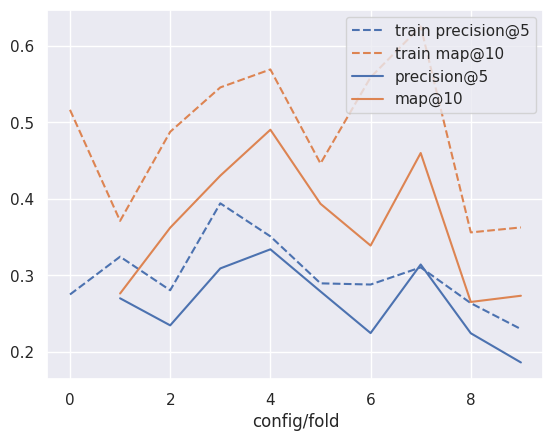

In [427]:
_toplot = best_realistic.copy()
_toplot.index = pd.to_numeric(_toplot.index)

ax = best[cols2plot].rename(columns='train {}'.format).plot(style='--', color=[l.get_color() for l in ax.lines])
# plt.xticks(range(10))
# bdf[cols2plot].rename(columns='baseline {}'.format).reset_index(drop=True).plot(ax=ax, style=':', color=[l.get_color() for l in ax.lines])

_toplot[cols2plot].plot(ax=ax)
# ax.set_ylim(0, 1)

_toplot[cols2plot].describe()

In [428]:
best.index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64', name='config/fold')

In [429]:
_PERFECT_NAME = 'Ground Truth'
_LEAK_NAME = 'Leaky GNN'
CAT_ORDER = [_PERFECT_NAME, _LEAK_NAME, 'GNN', 'OpenPop']

def _get_toplot_table(metrics2plot=cols2plot, oracle=True, perfect=None, week_index=True):
    if perfect is None:
        perfect = metrics2plot
    
    # _toplot = best_realistic.copy()
    # _toplot.index = pd.to_numeric(_toplot.index)
    # _toplot['fold'] = _toplot.index
    
    _toplot_real = best_realistic[metrics2plot].copy()
    _toplot_real['fold'] = _toplot_real.index.astype(int)
    _toplot_real['rec'] = 'GNN'

    _toplot_base = bdf[metrics2plot].copy()
    fold2str = _toplot_base.index.strftime('%G-W%V')
    _toplot_base['fold'] = range(len(_toplot_base))
    _toplot_base['rec'] = 'OpenPop'

    # _colsbest = map("best_{}".format, _cols)
    if oracle:
        _toplot_best = best[metrics2plot].copy() # [_colsbest].rename(columns=lambda x: x.split("_", 1)[-1])
        _toplot_best['fold'] = _toplot_best.index
        _toplot_best['rec'] = _LEAK_NAME
    else:
        _toplot_best = None
        _toplot_base = _toplot_base[_toplot_base['fold'] > 0]
        _toplot_real = _toplot_real[_toplot_real['fold'] > 0]

    if perfect:
        _toplot_perfect = pdf[perfect].copy()
        _toplot_perfect['fold'] = range(len(_toplot_perfect))
        _toplot_perfect['rec'] = _PERFECT_NAME
        # Make same len as baseline
        _toplot_perfect = _toplot_perfect.iloc[-len(_toplot_base):]
        assert _toplot_perfect.index.equals(_toplot_base.index)
    else:
        _toplot_perfect = None
        
    _toplot = (
        pd.concat((
            _toplot_real, 
            _toplot_best,
            _toplot_base,
            _toplot_perfect,
        ), ignore_index=True)
        .melt(id_vars=['fold', 'rec'], value_vars=metrics2plot, var_name='metric')
    )
    assert not (_toplot['fold'].isna()).any()
    
    _toplot['rec'] = pd.Categorical(_toplot['rec'], CAT_ORDER)
    _toplot['fold_week'] = fold2str[_toplot['fold']]

    return _toplot.sort_values('fold')

_tablecols = ['precision@5', 'precision@10', 'recall@5', 'recall@10', 'map@5', 'map@10', 'ndcg@5', 'ndcg@10']
_table = _get_toplot_table(_tablecols)
_table = _table[_table['fold'] >= 1]
print(_table.groupby(['rec', 'metric'])['value'].mean().unstack(level=-1)[_tablecols].rename(
    index={
        'Perfect': 'Ground Truth',
        'realistic': 'GNN'
    }
).style.format(precision=2).to_latex())
_table.groupby(['rec', 'metric']).describe()

\begin{tabular}{lrrrrrrrr}
metric & precision@5 & precision@10 & recall@5 & recall@10 & map@5 & map@10 & ndcg@5 & ndcg@10 \\
rec &  &  &  &  &  &  &  &  \\
Ground Truth & 0.48 & 0.28 & 0.95 & 0.99 & 0.95 & 0.99 & 1.00 & 1.00 \\
Leaky GNN & 0.30 & 0.23 & 0.56 & 0.79 & 0.41 & 0.48 & 0.51 & 0.59 \\
GNN & 0.26 & 0.22 & 0.45 & 0.71 & 0.29 & 0.37 & 0.39 & 0.48 \\
OpenPop & 0.22 & 0.20 & 0.34 & 0.63 & 0.23 & 0.30 & 0.31 & 0.41 \\
\end{tabular}



fold                                         value  \
                          count mean       std  min  25%  50%  75%  max count   
rec          metric                                                             
Ground Truth map@10         9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             map@5          9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             ndcg@10        9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             ndcg@5         9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             precision@10   9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             precision@5    9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             recall@10      9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             recall@5       9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
Leaky GNN    map@10         9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             map@5          9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             ndcg@10        9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             ndcg@5         9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             precision@10   9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             precision@5    9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             recall@10      9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             recall@5       9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
GNN          map@10         9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             map@5          9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             ndcg@10        9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             ndcg@5         9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             precision@10   9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             precision@5    9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             recall@10      9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             recall@5       9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
OpenPop      map@10         9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             map@5          9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             ndcg@10        9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             ndcg@5         9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             precision@10   9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             precision@5    9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             recall@10      9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   
             recall@5       9.0  5.0  2.738613  1.0  3.0  5.0  7.0  9.0   9.0   

                                                                             \
                               mean       std       min       25%       50%   
rec          metric                                                           
Ground Truth map@10        0.988565  0.013974  0.957778  0.987097  0.995293   
             map@5         0.945960  0.040382  0.856496  0.947488  0.953844   
             ndcg@10       1.000000  0.000000  1.000000  1.000000  1.000000   
             ndcg@5        1.000000  0.000000  1.000000  1.000000  1.000000   
             precision@10  0.284337  0.055883  0.223364  0.252113  0.284158   
             precision@5   0.482324  0.056450  0.421622  0.436620  0.491566   
             recall@10     0.988565  0.013974  0.957778  0.987097  0.995293   
             recall@5      0.945960  0.040382  0.856496  0.947488  0.953844   
Leaky GNN    map@10        0.480282  0.101158  0.356020  0.371106  0.487608   
             map@5         0.406073  0.103235  0.272603  0.298885  0.434213   
             ndcg@10       0.592760  0.091301  0.486249  0.490734  0.591702   
             ndcg@5        0.510438  0.087328  0.396441  0.436734  0.541738   
      

/tmp/ipykernel_50811/4283414865.py:17: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



count      mean       std       min       25%  \
rec          metric                                                       
Ground Truth map@10        10.0  0.989542  0.013532  0.957778  0.987893   
             precision@5   10.0  0.478408  0.054643  0.421622  0.437278   
Leaky GNN    map@10        10.0  0.483888  0.096052  0.356020  0.389869   
             precision@5   10.0  0.300486  0.046787  0.229577  0.276197   
GNN          map@10         9.0  0.365456  0.084257  0.265038  0.276081   
             precision@5    9.0  0.263800  0.049743  0.185915  0.224324   
OpenPop      map@10        10.0  0.310075  0.070509  0.212009  0.250209   
             precision@5   10.0  0.221133  0.036484  0.175100  0.189996   

                               50%       75%       max  
rec          metric                                     
Ground Truth map@10       0.996039  0.997944  1.000000  
             precision@5  0.467366  0.503698  0.595266  
Leaky GNN    map@10       0.501977  0.555588  0.625411  
             precision@5  0.288616  0.320765  0.394059  
GNN          map@10       0.362174  0.430213  0.490331  
             precision@5  0.269822  0.308911  0.333898  
OpenPop      map@10       0.304259  0.366326  0.417010  
             precision@5  0.225931  0.239061  0.287129

Cannot show ipywidgets in text

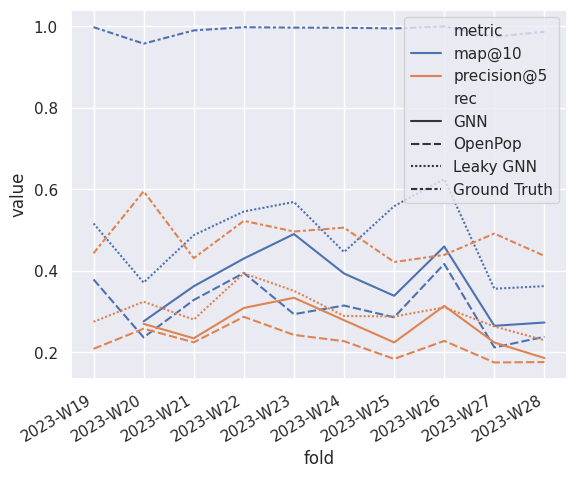

In [430]:
def plot_gnn_results(metrics2plot=cols2plot, oracle=False, perfect=None):
    _toplot = _get_toplot_table(metrics2plot, oracle, perfect)

    ax = sns.lineplot(
        _toplot, x='fold_week', y='value', 
        hue='metric' if len(metrics2plot) > 1 else None, 
        style='rec',
        style_order=['GNN', 'OpenPop', _LEAK_NAME, _PERFECT_NAME],
    )
    ax.set_xlabel('fold')
    
    if len(metrics2plot) == 1:
        ax.set_ylabel(metrics2plot[0])
        ax.legend_.set_title(None)

    # ax.set_xticks(ax.get_xticks()[1:-1], _toplot_base.index.strftime('%G-W%V'), rotation=30, ha='right')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

    display(_toplot.groupby(['rec', 'metric'])['value'].describe())
    # print(_toplot.groupby(['rec', 'metric'])['value'].describe()[['mean', 'std', '50%', 'min', 'max']].to_html())

    return ax

ax = plot_gnn_results(oracle=True) # perfect=['precision@5'])
download_matplotlib(ax.figure, '09_gnn_results.pdf')

/tmp/ipykernel_50811/4283414865.py:17: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



count      mean       std       min       25%  \
rec          metric                                                       
Ground Truth precision@5    9.0  0.482324  0.056450  0.421622  0.436620   
GNN          precision@5    9.0  0.263800  0.049743  0.185915  0.224324   
OpenPop      precision@5    9.0  0.222521  0.038416  0.175100  0.183784   

                               50%       75%       max  
rec          metric                                     
Ground Truth precision@5  0.491566  0.506061  0.595266  
GNN          precision@5  0.269822  0.308911  0.333898  
OpenPop      precision@5  0.227273  0.242735  0.287129

Cannot show ipywidgets in text

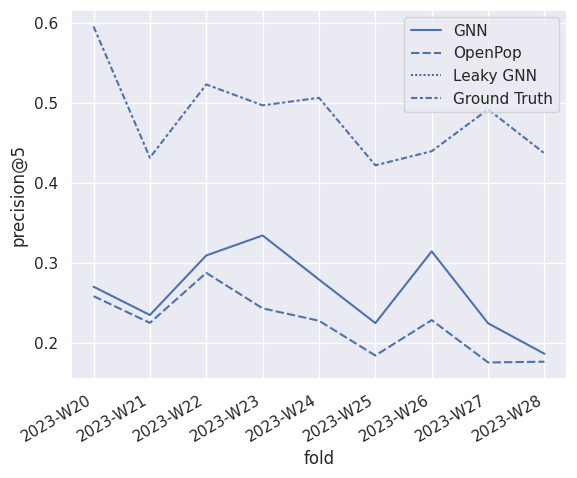

In [431]:
ax = plot_gnn_results(['precision@5'])
ax.figure.savefig('../figures/09_gnn_results_precision_5.png', bbox_inches='tight')
download_matplotlib(ax.figure, '09_gnn_results_precision_5.pdf')

/tmp/ipykernel_50811/4283414865.py:17: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



count      mean       std       min       25%  \
rec          metric                                                       
Ground Truth precision@5   10.0  0.478408  0.054643  0.421622  0.437278   
Leaky GNN    precision@5   10.0  0.300486  0.046787  0.229577  0.276197   
GNN          precision@5    9.0  0.263800  0.049743  0.185915  0.224324   
OpenPop      precision@5   10.0  0.221133  0.036484  0.175100  0.189996   

                               50%       75%       max  
rec          metric                                     
Ground Truth precision@5  0.467366  0.503698  0.595266  
Leaky GNN    precision@5  0.288616  0.320765  0.394059  
GNN          precision@5  0.269822  0.308911  0.333898  
OpenPop      precision@5  0.225931  0.239061  0.287129

Cannot show ipywidgets in text

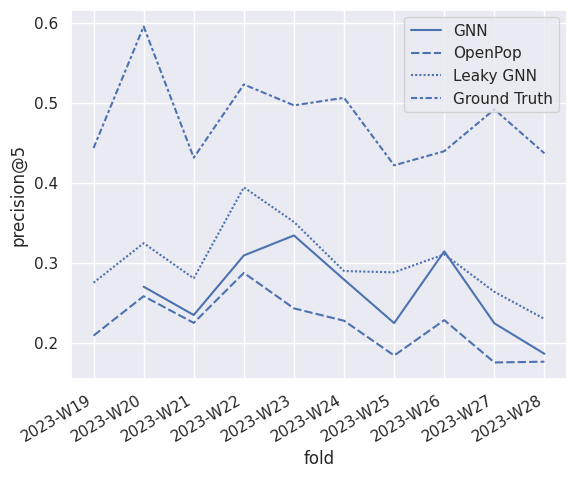

In [432]:
ax = plot_gnn_results(['precision@5'], oracle=True)
download_matplotlib(ax.figure, '09_gnn_results_precision_5_leaky.pdf')

/tmp/ipykernel_50811/4283414865.py:17: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



count      mean       std       min       25%       50%  \
rec          metric                                                            
Ground Truth map@10    9.0  0.988565  0.013974  0.957778  0.987097  0.995293   
GNN          map@10    9.0  0.365456  0.084257  0.265038  0.276081  0.362174   
OpenPop      map@10    9.0  0.302421  0.070242  0.212009  0.238254  0.293672   

                          75%       max  
rec          metric                      
Ground Truth map@10  0.997175  1.000000  
GNN          map@10  0.430213  0.490331  
OpenPop      map@10  0.328419  0.417010

Cannot show ipywidgets in text

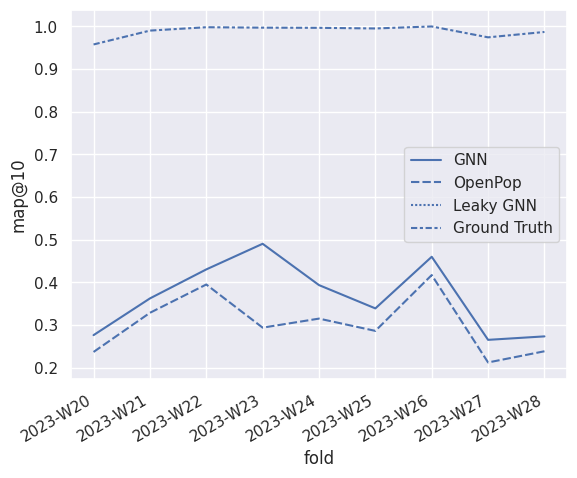

In [433]:
ax = plot_gnn_results(['map@10']) #, perfect=False)
ax.figure.savefig('../figures/09_gnn_results_map_10.png', bbox_inches='tight')
download_matplotlib(ax.figure, '09_gnn_results_map_10.pdf')

/tmp/ipykernel_50811/4283414865.py:17: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



count      mean       std       min       25%       50%  \
rec          metric                                                             
Ground Truth ndcg@10    9.0  1.000000  0.000000  1.000000  1.000000  1.000000   
GNN          ndcg@10    9.0  0.481909  0.088338  0.388354  0.399515  0.472761   
OpenPop      ndcg@10    9.0  0.412389  0.081827  0.317482  0.356396  0.406611   

                           75%       max  
rec          metric                       
Ground Truth ndcg@10  1.000000  1.000000  
GNN          ndcg@10  0.537640  0.615145  
OpenPop      ndcg@10  0.435318  0.569957

Cannot show ipywidgets in text

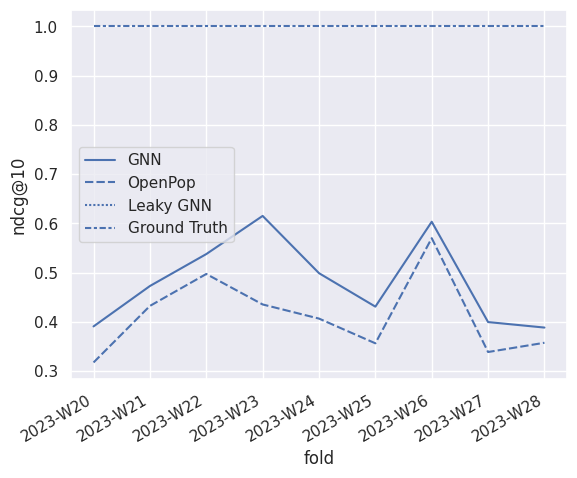

In [434]:
ax = plot_gnn_results(['ndcg@10']) #, perfect=False)
ax.figure.savefig('../figures/09_gnn_results_ndcg_10.png', bbox_inches='tight')
download_matplotlib(ax.figure, '09_gnn_results_ndcg_10.pdf')

/tmp/ipykernel_50811/4283414865.py:17: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



count      mean       std       min       25%       50%  \
rec          metric                                                             
Ground Truth ndcg@10   10.0  1.000000  0.000000  1.000000  1.000000  1.000000   
Leaky GNN    ndcg@10   10.0  0.594112  0.086186  0.486249  0.508214  0.598992   
GNN          ndcg@10    9.0  0.481909  0.088338  0.388354  0.399515  0.472761   
OpenPop      ndcg@10   10.0  0.415757  0.077879  0.317482  0.356670  0.419471   

                           75%       max  
rec          metric                       
Ground Truth ndcg@10  1.000000  1.000000  
Leaky GNN    ndcg@10  0.660281  0.731740  
GNN          ndcg@10  0.537640  0.615145  
OpenPop      ndcg@10  0.443381  0.569957

Cannot show ipywidgets in text

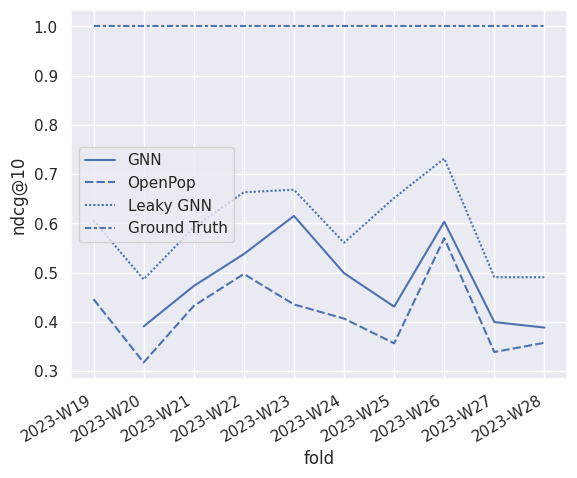

In [435]:
ax = plot_gnn_results(['ndcg@10'], oracle=True)
download_matplotlib(ax.figure, '09_gnn_results_ndcg_10_leaky.pdf')